### Chapter6_Queation 8

In this exercise, we will generate simulated data, and will then use this data to perform forward and backward stepwise selection.

(a) Create a random number generator and use its normal() method to generate a predictor $X$ of length n = 100, as well as a noise
vector $\epsilon$ of length n = 100.

In [1]:
import numpy as np

rng = np.random.default_rng(314657018)
n = 100
X = rng.normal(size=n)

epsilon = rng.normal(size=n)

print("X shape:", X.shape)
print("epsilon shape:", epsilon.shape)


X shape: (100,)
epsilon shape: (100,)


(b) Generate a response vector $Y$ of length n = 100 according to the model:

$
Y= β_{0} + β_{1}X + β_{2}X^{2} + β_{3}X^{3} + \epsilon,
$

where $β_{0}$, $β_{1}$, $β_{2}$ and $β_{3}$ are constants of your choice.

In [2]:
b0, b1, b2, b3 = 1.0,2.0,-1.5,0.5
X2, X3 = X**2, X**3
Y = b0 + b1*X + b2*X2 + b3*X3 + epsilon

# 檢查形狀
print("Y shape:", Y.shape)
print("前 10 筆 Y：", Y[:10])

Y shape: (100,)
前 10 筆 Y： [ -4.000941    -3.8156813   -2.95637135   1.0770103    3.00950739
   2.31961185  -3.55531219 -16.2723901   -0.50670709   1.55147229]


(c) Use forward stepwise selection in order to select a model containing the predictors $X$, $X^2$, . . . , $X^{10}$. What is the model obtained according to $C_{p}$? Report the coefficients of the model obtained.

In [6]:
import pandas as pd 
import statsmodels.api as sm
predictor_names = [f"X^{k}" for k in range(1, 11)]
df = pd.DataFrame({name: X**k for k, name in enumerate(predictor_names, start=1)})
df["Y"] = Y

# Step 1：用 full model 估計 sigma^2（for Cp）
X_full = sm.add_constant(df[predictor_names])
full_model = sm.OLS(df["Y"], X_full).fit()
rss_full = np.sum(full_model.resid**2)
sigma2_hat = rss_full / full_model.df_resid
n = len(Y)

# Step 2：Forward Stepwise
available = predictor_names.copy()
selected = []
results = []

for step in range(1, len(predictor_names) + 1):
    best_var = None
    best_cp = None
    best_model = None
    best_list = None

    for var in available:
        trial_list = selected + [var]
        X_trial = sm.add_constant(df[trial_list])
        model_trial = sm.OLS(df["Y"], X_trial).fit()

        rss = np.sum(model_trial.resid**2)
        p = X_trial.shape[1]  # 含截距
        cp = (rss / sigma2_hat) - n + 2 * p

        if (best_cp is None) or (cp < best_cp):
            best_cp = cp
            best_var = var
            best_model = model_trial
            best_list = trial_list

    selected.append(best_var)
    available.remove(best_var)
    results.append((best_list, best_cp, best_model))

# 取 Cp 最小者
cp_values = [r[1] for r in results]
best_index = int(np.argmin(cp_values))
best_vars, best_cp, best_model = results[best_index]

# -----------------------------
# 結果輸出
# -----------------------------
print("\n==============================")
print("Mallows' Cp 最佳模型")
print("==============================")
print("選到的變數:", best_vars)
print("最小 Cp:", best_cp)

print("\n迴歸係數：")
print(best_model.params)


Mallows' Cp 最佳模型
選到的變數: ['X^3', 'X^2', 'X^1']
最小 Cp: 2.1732661467667924

迴歸係數：
const    1.107990
X^3      0.436792
X^2     -1.416647
X^1      2.129589
dtype: float64


(d) Repeat (c), using backwards stepwise selection. How does your answer compare to the results in (c)?

In [7]:
available = predictor_names.copy()
selected = predictor_names.copy()   # backward 起始：所有變數都在
results_backward = []

for step in range(len(predictor_names), 0, -1):

    best_cp = None
    best_model = None
    best_list = None

    # 嘗試移除每一個候選變數
    for var in selected:

        trial_list = [v for v in selected if v != var]  # 移除 var
        X_trial = sm.add_constant(df[trial_list])
        model_trial = sm.OLS(df["Y"], X_trial).fit()

        rss = np.sum(model_trial.resid**2)
        p = X_trial.shape[1]  # 含截距
        cp = (rss / sigma2_hat) - n + 2 * p

        if (best_cp is None) or (cp < best_cp):
            best_cp = cp
            best_model = model_trial
            best_list = trial_list

    # 更新：移除後最好的組合
    selected = best_list.copy()
    results_backward.append((best_list, best_cp, best_model))

# 找出 Cp 最小的模型
cp_values_bwd = [r[1] for r in results_backward]
best_index_bwd = int(np.argmin(cp_values_bwd))
best_vars_bwd, best_cp_bwd, best_model_bwd = results_backward[best_index_bwd]

# -----------------------------
# 結果輸出
# -----------------------------
print("\n==============================")
print("Backward Mallows' Cp 最佳模型")
print("==============================")
print("選到的變數:", best_vars_bwd)
print("最小 Cp:", best_cp_bwd)

print("\n迴歸係數：")
print(best_model_bwd.params)


Backward Mallows' Cp 最佳模型
選到的變數: ['X^1', 'X^2', 'X^3']
最小 Cp: 2.173266146766821

迴歸係數：
const    1.107990
X^1      2.129589
X^2     -1.416647
X^3      0.436792
dtype: float64


(e) Now fit a lasso model to the simulated data, again using $X$, $X^{2}$, ... , $X^{10}$ as predictors. Use cross-validation to select the optimal value of $\lambda$. Create plots of the cross-validation error as a function of $\lambda$. Report the resulting coefficient estimates, and discuss the results obtained.

最佳 λ (alpha): 0.033338925761430105

Lasso（標準化後的係數）:
X^1: 2.1258
X^2: -1.5578
X^3: 1.1818
X^4: -0.2862
X^5: 0.1508
X^6: -0.0000
X^7: 0.0000
X^8: -0.0000
X^9: 0.0000
X^10: -0.0000


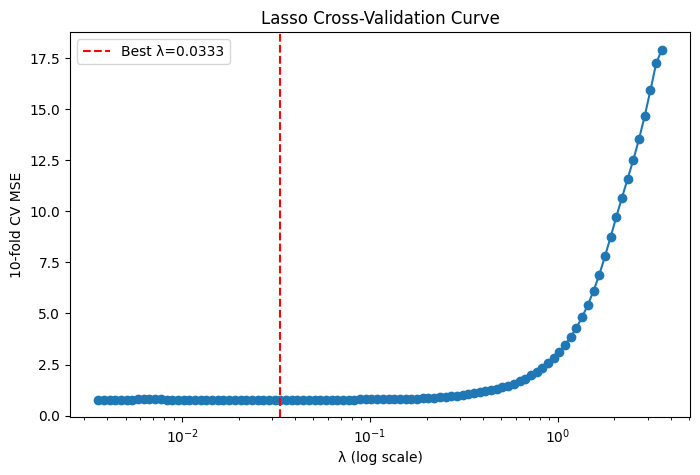

In [8]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# 準備 X matrix（10 個多項式）
X_mat = df[predictor_names].values
y = df["Y"].values

# 使用 pipeline：先標準化，再做 LassoCV（避免不同次方尺度差異）
lasso_cv = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", LassoCV(cv=10, random_state=314657018))
])

lasso_cv.fit(X_mat, y)

# 取出最佳 λ（在 sklearn 中叫 α）
best_lambda = lasso_cv.named_steps["lasso"].alpha_
print("最佳 λ (alpha):", best_lambda)

# 取出每個係數（還在 standardized scale，要換回原始 scale 才有意義）
coef_scaled = lasso_cv.named_steps["lasso"].coef_
intercept_scaled = lasso_cv.named_steps["lasso"].intercept_

print("\nLasso（標準化後的係數）:")
for name, c in zip(predictor_names, coef_scaled):
    print(f"{name}: {c:.4f}")


# ---------------------------
# 畫 CV MSE vs λ 曲線
# ---------------------------
lasso_cv_model = lasso_cv.named_steps["lasso"]

mse_path = lasso_cv_model.mse_path_.mean(axis=1)
lambdas = lasso_cv_model.alphas_

plt.figure(figsize=(8,5))
plt.plot(lambdas, mse_path, marker="o")
plt.axvline(best_lambda, color="red", linestyle="--", label=f"Best λ={best_lambda:.4f}")
plt.xscale("log")
plt.xlabel("λ (log scale)")
plt.ylabel("10-fold CV MSE")
plt.title("Lasso Cross-Validation Curve")
plt.legend()
plt.show()


In [9]:
# ===== 把 Lasso 係數從 standardized scale 轉回原始 scale =====
scaler = lasso_cv.named_steps["scaler"]

beta_raw = coef_scaled / scaler.scale_
intercept_raw = intercept_scaled - np.sum(scaler.mean_ * beta_raw)

print("\nLasso（轉回原始尺度的係數）：")
print(f"Intercept: {intercept_raw:.4f}")
for name, b in zip(predictor_names, beta_raw):
    print(f"{name}: {b:.4f}")



Lasso（轉回原始尺度的係數）：
Intercept: 1.0064
X^1: 2.1796
X^2: -1.1936
X^3: 0.3690
X^4: -0.0449
X^5: 0.0098
X^6: -0.0000
X^7: 0.0000
X^8: -0.0000
X^9: 0.0000
X^10: -0.0000


(f) Now generate a response vector $Y$ according to the model

$
Y= \beta_{0} + \beta_{7}X^{7} + \epsilon,
$

and perform forward stepwise selection and the lasso. Discuss the results obtained.


=== Forward Stepwise (Mallows' Cp) Result ===
Selected variables (best Cp): ['X^7']
Cp value: 0.4207926542323861

OLS coefficients for that model:
const    1.183300
X^7      2.998457
dtype: float64

=== LassoCV Result ===
Best alpha (lambda): 0.2425358669032745

Lasso coefficients (on standardized X):
X^1      -1.030714
X^2      -0.000000
X^3       0.000000
X^4      -0.000000
X^5      41.513478
X^6      -1.168737
X^7     144.506011
X^8      -0.000000
X^9      57.753348
X^10     -0.000000
dtype: float64

Predictors with non-zero coefficients (Lasso): ['X^1', 'X^5', 'X^6', 'X^7', 'X^9']


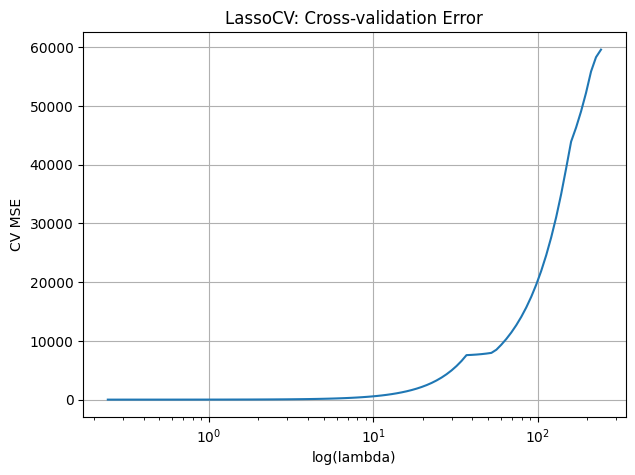

In [11]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# -----------------------------
# (1) 重新生成資料：Y = beta0 + beta7 X^7 + epsilon
# -----------------------------
rng = np.random.default_rng(314657018)
n = 100
X = rng.normal(size=n)
epsilon = rng.normal(size=n)

beta0 = 1.0
beta7 = 3.0

Y = beta0 + beta7 * X**7 + epsilon

# -----------------------------
# 建立 X^1 ... X^10 DataFrame
# -----------------------------
predictor_names = [f"X^{k}" for k in range(1, 11)]
df = pd.DataFrame({name: X**k for k, name in enumerate(predictor_names, start=1)})
df["Y"] = Y

# -----------------------------
# (2) Stepwise Forward using Mallows' Cp
# -----------------------------
# 先用 full model 估計 sigma^2
X_full = sm.add_constant(df[predictor_names])
full_model = sm.OLS(df["Y"], X_full).fit()
rss_full = np.sum(full_model.resid**2)
sigma2_hat = rss_full / full_model.df_resid

available = predictor_names.copy()
selected = []
results = []

for step in range(1, len(predictor_names) + 1):

    best_var = None
    best_cp = None
    best_model = None
    best_list = None

    for var in available:
        trial_list = selected + [var]
        X_trial = sm.add_constant(df[trial_list])
        model_trial = sm.OLS(df["Y"], X_trial).fit()

        rss = np.sum(model_trial.resid**2)
        p = X_trial.shape[1]  # 含截距
        cp = (rss / sigma2_hat) - n + 2 * p

        if (best_cp is None) or (cp < best_cp):
            best_cp = cp
            best_var = var
            best_model = model_trial
            best_list = trial_list

    selected.append(best_var)
    available.remove(best_var)
    results.append((best_list, best_cp, best_model))

# Cp 最佳模型
cp_values = [r[1] for r in results]
best_index = int(np.argmin(cp_values))
best_vars, best_cp, best_model = results[best_index]

print("\n=== Forward Stepwise (Mallows' Cp) Result ===")
print("Selected variables (best Cp):", best_vars)
print("Cp value:", best_cp)
print("\nOLS coefficients for that model:")
print(best_model.params)


# -----------------------------
# (3) LassoCV
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[predictor_names])

lasso = LassoCV(cv=10, random_state=314657018)
lasso.fit(X_scaled, Y)

# Lasso 係數（對應經標準化資料）
lasso_coefs = pd.Series(lasso.coef_, index=predictor_names)

print("\n=== LassoCV Result ===")
print("Best alpha (lambda):", lasso.alpha_)
print("\nLasso coefficients (on standardized X):")
print(lasso_coefs)

print("\nPredictors with non-zero coefficients (Lasso):",
      list(lasso_coefs[lasso_coefs != 0].index))

# -----------------------------
# Lasso CV MSE 圖
# -----------------------------
plt.figure(figsize=(7, 5))
plt.plot(lasso.alphas_, np.mean(lasso.mse_path_, axis=1))
plt.xscale("log")
plt.xlabel("log(lambda)")
plt.ylabel("CV MSE")
plt.title("LassoCV: Cross-validation Error")
plt.grid(True)
plt.show()
